In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
input_dir = "/kaggle/input/train-file-new/Train/Train/low"
output_dir = 'denoised_images'
original_dir ="/kaggle/input/train-file-new/Train/Train/high"

os.makedirs(output_dir, exist_ok=True)

def denoise_image(input_path, output_path, h=10, hForColorComponents=10, templateWindowSize=7, searchWindowSize=21):
    noisy_image = cv2.imread(input_path)
    denoised_image = cv2.fastNlMeansDenoisingColored(noisy_image, None, h, hForColorComponents, templateWindowSize, searchWindowSize)
    
    cv2.imwrite(output_path, denoised_image)
    
    return denoised_image
psnr_values = []
for filename in os.listdir(input_dir):
    if filename.lower().endswith(".png"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        original_path = os.path.join(original_dir, filename)
        
        denoised_image = denoise_image(input_path, output_path)
        original_image = cv2.imread(original_path)
        
        if denoised_image is not None and original_image is not None:
            # Calculate PSNR
            psnr_value = psnr(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
            psnr_values.append(psnr_value)
        else:
            print(f"Error loading images for {filename}")
if psnr_values:
    average_psnr = np.mean(psnr_values)
    print(f"Average PSNR: {average_psnr}")

print("Denoising completed. Denoised images are saved in:", output_dir)

Average PSNR: 7.683715260750904
Denoising completed. Denoised images are saved in: denoised_images


In [4]:
import numpy as np 
import pandas as pd
import os 
import pickle
from imageio.v2 import imread
import imageio.v2

In [5]:
def numerical_sort(value):
    numeric_part = ''.join(filter(str.isdigit, value))
    if numeric_part:
        return int(numeric_part)
    else:
        return float('inf')

def save_images_in_chunks(low_dir, high_dir, chunk_size=100):
    low_images = []
    high_images = []
    low_files = sorted(os.listdir(low_dir), key=numerical_sort)
    high_files = sorted(os.listdir(high_dir), key=numerical_sort)

    for i, (low_file, high_file) in enumerate(zip(low_files, high_files)):
        if low_file.endswith('.png') and high_file.endswith('.png'):
            low_img_path = os.path.join(low_dir, low_file)
            high_img_path = os.path.join(high_dir, high_file)
            low_images.append(imageio.v2.imread(low_img_path))
            high_images.append(imageio.v2.imread(high_img_path))

        if (i + 1) % chunk_size == 0 or (i + 1) == len(low_files):
            chunk_index = i // chunk_size
            with open(f'low_images_chunk_{chunk_index}.pkl', 'wb') as f:
                pickle.dump(low_images, f)
            with open(f'high_images_chunk_{chunk_index}.pkl', 'wb') as f:
                pickle.dump(high_images, f)
            print(f'Saved chunk {chunk_index}')
            low_images = []
            high_images = []

def load_images_from_chunks(low_chunk_files, high_chunk_files):
    low_images = []
    high_images = []
# pickle.load() is used to load previously serialized (pickled) images from chunk files.
    for low_chunk_file, high_chunk_file in zip(low_chunk_files, high_chunk_files):
        with open(low_chunk_file, 'rb') as f:
            chunk_low_images = pickle.load(f)
            low_images.extend(chunk_low_images)
        with open(high_chunk_file, 'rb') as f:
            chunk_high_images = pickle.load(f)
            high_images.extend(chunk_high_images)

    low_images_normalized = np.array(low_images) / 255.0
    high_images_normalized = np.array(high_images) / 255.0

    return low_images_normalized, high_images_normalized

low_dir = "/kaggle/working/denoised_images"
high_dir = "/kaggle/input/train-file-new/Train/Train/high"
save_images_in_chunks(low_dir, high_dir, chunk_size=100)

low_chunk_files = [f'low_images_chunk_{i}.pkl' for i in range(len(os.listdir(low_dir)) // 100 + 1)]
high_chunk_files = [f'high_images_chunk_{i}.pkl' for i in range(len(os.listdir(high_dir)) // 100 + 1)]

low_images_normalized, high_images_normalized = load_images_from_chunks(low_chunk_files, high_chunk_files)
print(low_images_normalized.shape, high_images_normalized.shape)

Saved chunk 0
Saved chunk 1
Saved chunk 2
Saved chunk 3
Saved chunk 4
(485, 400, 600, 3) (485, 400, 600, 3)


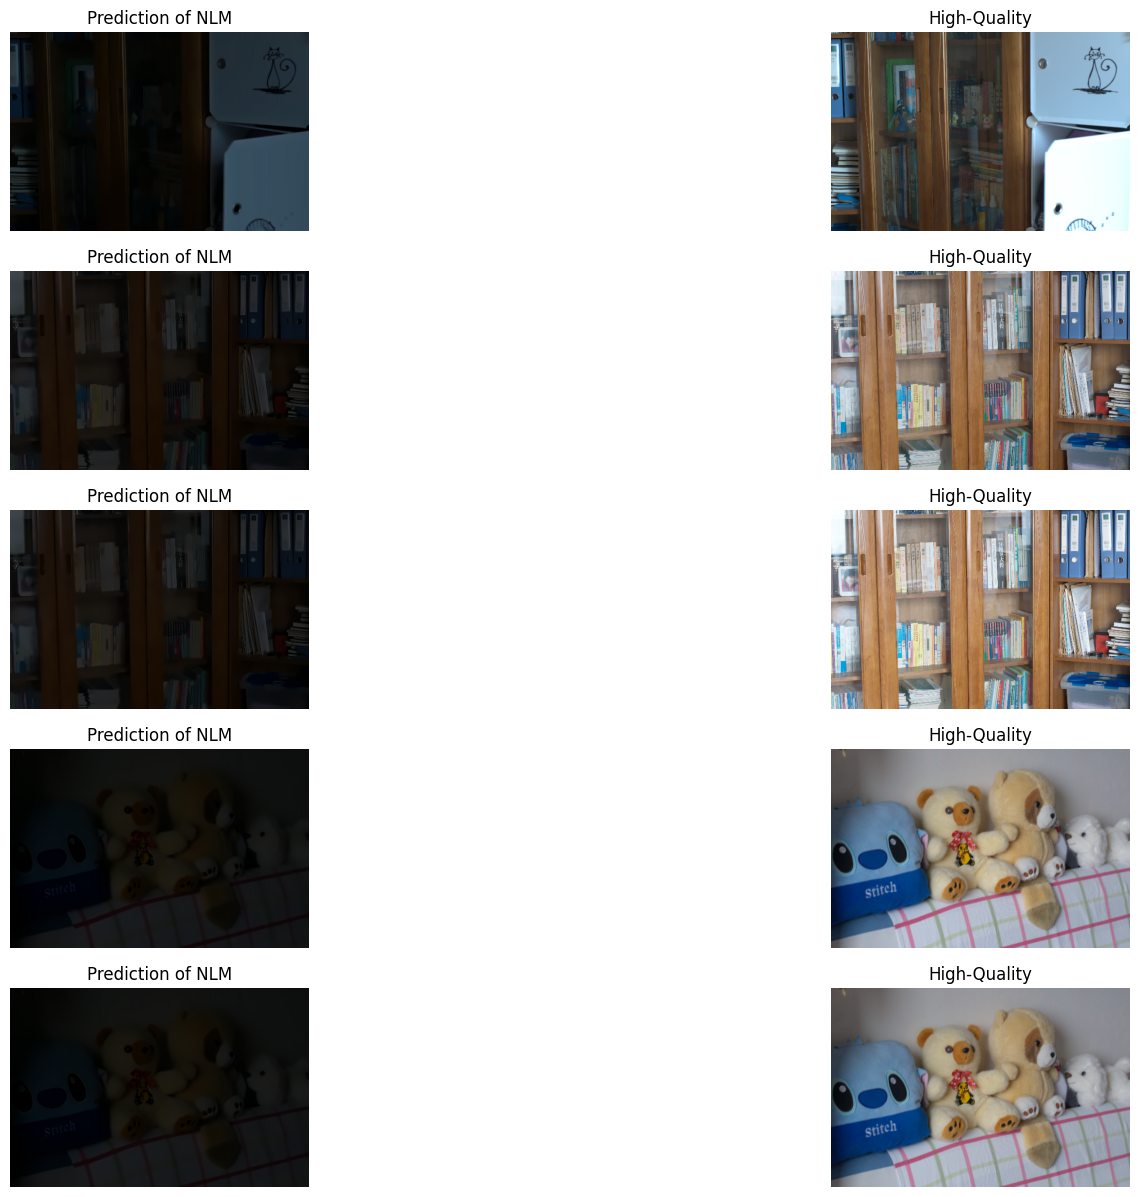

In [8]:
import matplotlib.pyplot as plt

def plot_images(original, denoised, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        # Original low-quality image
        ax = plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(low_images_normalized[i])
        plt.title("Prediction of NLM")
        plt.axis("off")
        
        
        # Original high-quality image
        ax = plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(high_images_normalized[i])
        plt.title("High-Quality")
        plt.axis("off")
    
    plt.show()

plot_images(low_images_normalized,high_images_normalized, num_images=5)